Event Driven Simulation 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Scheduling CoMP
---------

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 
alpha=-np.log10(0.01)/100



def df_to_ue_lists(df,cluster,thr):

    cluster=[19,20]
    df_filter=df.groupby('PCI Serving')
    ue_dict={}
    for i in cluster:
        counter=0
        ue_list=np.array([])
        df2=df_filter.get_group(i)
        for j in df2.index:
            ue_list=np.append(ue_list, ue(df.iloc[j]['JT_1 SINR [lin]'],df.iloc[j]['JT_2 SINR [lin]'],df.iloc[j]['PCI Serving'],df.iloc[j]['PCI Coord'],env,df.iloc[j]['usage'], thr,df.iloc[j]['id']))
        ue_dict[i]= ue_list
    return ue_dict

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_prb_number(users,max_prb):
    count=0
    count2=0
    for i in np.arange(len(users)):
        if(users[i].comp ==1):
            if(users[i].qos==0):
                count+=1
            if(users[i].qos==1):
                count+=4
            if(users[i].qos==2):
                count+=75
                
        elif(users[i].comp ==0):
            if(users[i].qos==0):
                count2+=1
            if(users[i].qos==1):
                count2+=4
            if(users[i].qos==2):
                count2+=75
    prb_number=round(count/count2*max_prb)
    return prb_number

def get_dataframe(users):
    df=pd.DataFrame()
    sinr=np.array([])
    sinr2=np.array([])
    tbs=np.array([])
    queue=np.array([])
    
    for i in np.arange(np.size(users)):
        sinr=np.append(sinr,users[i].sinr)
        sinr2=np.append(sinr,users[i].sinr2)
        tbs=np.append(sinr,users[i].tbs)
        queue=np.append(sinr,users[i].queue)
    df['sinr']=sinr
    df['sinr2']=sinr2
    df['tbs']=tbs
    df['queue']=queue
    return df

def calculate_tbs(sinr,sinr2):
    sinr=int(sinr)
    sinr2=int(sinr2)
    if(sinr>30 or sinr2>30):
        print('sinr out of range')
        tbs=30
        tbs2=30
    elif(sinr<-10):
        print('sinr out of range')
        tbs=-10
        tbs2=-10
    else:
        mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
        tbs=mapping.iloc[sinr].values[1]
        tbs2=mapping.iloc[sinr2].values[1]
    return tbs,tbs2

def metric_list_nC(users,sched_exp,counter):
    e1=sched_exp[0]
    e2=sched_exp[1]
    metric=np.array([])

    for i in users: 
        if(i.qos==1 or i.qos==2):
            metric=np.append(metric, (alpha*i.queue.level*((i.cp)**e1/(i.mR)**e2)))  #list the metric of all UEs in the process 
            i.mR=(1-1/counter)*i.mR #Ratenanpassung für alle Nutzer    
        elif(i.qos==0):
            if(i.queue.level>0):
                metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
                i.mR=(1-1/counter)*i.mR #Ratenanpassung für alle Nutzer
            elif(i.queue2.level==0):
                metric=np.append(metric,0)
                i.mR=(1-1/counter)*i.mR #Ratenanpassung für alle Nutzer
    sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
    return sched_user_list

def metric_list_C(users,sched_exp,counter,usage):
    e1=sched_exp[0]
    e2=sched_exp[1]
    metric=np.array([])
    for i in users: 
        if(usage=='nocomp'):
            cp=i.cp
        elif(usage=='comp'):
            cp=i.cp2
            
        if(i.qos==1 or i.qos==2):
            metric=np.append(metric, (alpha*i.queue2.level*(cp**e1/(i.mR2)**e2)))  #list the metric of all UEs in the process 
            i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer    
        elif(i.qos==0):
            if(i.queue2.level>0):
                metric=np.append(metric,((cp)**e1/(i.mR2)**e2))
                i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer
            elif(i.queue2.level==0):
                metric=np.append(metric,0)
                i.mR2=(1-1/counter)*i.mR2 #Ratenanpassung für alle Nutzer
    sched_user_list = (-metric).argsort() #sort UEs by metric that will be used for scheduling
    return sched_user_list


def central_scheduler(env, users, SCHEDULE_T,cluster, prb_number):
    
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
        
        sched_user_list=metric_list_C(users,[1,1],counter,'comp')
        
        remaining_prb_list={}
        for i in cluster:
            remaining_prb_list[i]=prb_number
            
        k=0
        free_res=1
        
        while(free_res==1):
            sched_user=sched_user_list[k]
            cell1=int(users[sched_user].cell1)
            cell2=int(users[sched_user].cell2)
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs
            tbs2=users[sched_user].tbs2
            remaining_prbs=remaining_prb_list[cell1]
            remaining_prbs_c2=remaining_prb_list[cell2]
            #print('Resourcen:',remaining_prb_list[cell1])
            #print('Resourcen:',remaining_prb_list[cell2])
            #serving cell has no resources left -> no scheduling 
            if(remaining_prbs_c2==0):
                #print('keine Res mehr frei')
                continue
            #cell to coordinate with has no resources left -> without comp
            elif(remaining_prbs_c2==0):
                #print('ohne CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs)
                
            elif((queue_size/tbs2)<=remaining_prbs and (queue_size/tbs2)<=remaining_prbs_c2 and queue_size>0):
            #comp can be used
                #print('mit CoMP')
                sched_size=queue_size
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(queue_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(queue_size/tbs2)
            #one of the cells has not enough resources left 
            elif((queue_size/tbs2)>remaining_prbs or (queue_size/tbs2)>remaining_prbs_c2):
                #print('mit CoMP - v2')
                sched_size=min(remaining_prbs,remaining_prbs_c2)*tbs2
                remaining_prb_list[cell1]=remaining_prbs-np.ceil(sched_size/tbs2)
                remaining_prb_list[cell2]=remaining_prbs_c2-np.ceil(sched_size/tbs2)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')

            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            #print('Queue nachher:',users[sched_user].queue.level)
            k=k+1
            free_res=0
            for i in cluster:
                if(remaining_prb_list[i]!=0):
                    free_res=1
                    
        counter=counter+2
        
        


#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T,cluster, prb_number, users2, prb_number2, sched_metric):
    
    counter=1 #counts the number of scheduling procedures
    bits1=0
    bits2=0
    while True: #größte Warteschlange wird auch bedient
        
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        
        for i in np.arange(len(users)):
            users[i].mon= monitor(users[i].queue,users[i].mon)
        
        sched_user_list=metric_list_nC(users,[1,1],counter)

        remaining_prbs=prb_number
        k=0
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
          
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            users[sched_user].bits+=sched_size
            k=k+1
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users[sched_user].mR)
                print(counter)
        #CoMP-Scheduling Process- Users with normal scheduling
        ############################
        
        sched_user_list = metric_list_C(users2,[1,1],counter,'nocomp') #calculates the ordered list with ues
        
        
        remaining_prbs=prb_number2
        k=0
        #print('New scheduling round')
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            queue_size=users2[sched_user].queue2.level
            tbs=users2[sched_user].tbs

            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-np.ceil(sched_size/tbs)
                
            elif(queue_size==0):
                print('empty queue')
                break
            else:
                print('something went wrong')
            
            users2[sched_user].mR2=users2[sched_user].mR2+(1/counter)*sched_size
            users2[sched_user].queue2.get(sched_size)
            users2[sched_user].bits2+=sched_size
            
            if(sched_user_list[k]==0 or sched_user_list[k]==1 or sched_user_list[k] ==2):
                print('ue-number sched1:', sched_user_list[k])
                print(users2[sched_user].mR2)
                print(counter)
            
            k=k+1
        ###########################

        counter=counter+2
        

class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos,thr,id):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs,self.tbs2=calculate_tbs(sinr,sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.mR2=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.queue2=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        self.metric2=self.sinr+self.queue.level
        self.gain=self.sinr2-self.sinr
        self.id=id
        self.bits=0
        self.bits2=0
        if(self.gain >thr):
            self.comp=np.array(1)
        else:
            self.comp=np.array(0) 
        
    def rt_user(self,env):
        on_off=1
        counter=0
        start=0
        while True:
            if(start==0):
                start=1
                yield env.timeout(random.randint(0,200))
            elif(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                self.queue2.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1

                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env,packet_arr):
        while True:
            #print('o-user')
            self.queue.put(2000)
            self.queue2.put(2000) 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(packet_arr, 1))
            

    def streaming_user(self,env):
        while True:
            #print('o-user')
            self.queue.put(150) #1080p-> 1.5 Mbps (normal 1500)
            self.queue2.put(150) #1080p-> 1.5 Mbps 
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(2)
    
    #Noch sehr vereinfacht!!!
    def sinr_variator(self,env):
        change=round(np.random.normal(0,0.5))
        if((self.sinr+change)>-10 and (self.sinr+change)<30): 
            self.sinr=self.sinr +change
            self.sinr2=self.sinr2+change 
        yield env.timeout(2000)


In [3]:
env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=50
thr=6
cluster=[19,20]


x=np.append(np.ones(70)*19,np.ones(70)*20)
y=np.append(np.ones(70)*20,np.ones(70)*19)
sinr=np.random.randint(0,12,70*2)
sinr2=np.random.randint(2,16,70*2)
rt_nrt=np.array([])
rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))

rt_nrt=np.append(rt_nrt,np.ones(50)*0)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,2)
rt_nrt=np.append(rt_nrt,1)
rt_nrt=np.append(rt_nrt,np.ones(17))


df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
df['id']=np.arange(0,140)
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')


ue_dict=df_to_ue_lists(df,[19,20],6)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp



In [4]:
#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,50):
        env.process(ue_list[j].user_packets(env,50))
        #env.process(ue_list[i].sinr_variator()) #movement
    env.process(ue_list[50].streaming_user(env))
    env.process(ue_list[51].streaming_user(env))
    #env.process(ue_list[100].sinr_variator()) #movement   
    for j in np.arange(52,70):
        env.process(ue_list[j].rt_user(env))
        #env.process(ue_list[i].sinr_variator()) #movement

        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_19=ue_all[counter*70:((counter+1)*70-1)]
    env.process(scheduler(env,ue_list,SCHEDULE_T,[19,20],prb_number_normal,ue_19,50,1))
env.run(until=5000)

<ipython-input-2-431104769901>:123: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))
<ipython-input-2-431104769901>:119: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(cp**e1/(i.mR2)**e2)))  #list the metric of all UEs in the process
<ipython-input-2-431104769901>:119: RuntimeWarning: invalid value encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue2.level*(cp**e1/(i.mR2)**e2)))  #list the metric of all UEs in the process
<ipython-input-2-431104769901>:100: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
<ipython-input-2-431104769901>:96: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric, (alpha*i.queue.level*((i.cp)**e1/(i.mR)**e2)))  #list the metric of all UEs in the process
<ipython-input-2-431104769901>:96: RuntimeWarning: invalid value e

ue-number sched1: 0
2000.0
1
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
45.238095238095234
21
ue-number sched1: 2
80.8695652173913
23
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
45.57274562118801
39
empty queue
ue-number sched1: 2
34.02439024390244
41
empty queue
ue-number sched1: 2
7.441860465116279
43
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
3.3962264150943393
53
ue-number sched1: 2
21.68181818181818
55
ue-number sched1: 2
36.79387583184345
55
empty queue
empty queue
ue-number sched1: 1
58.33247385229136
59
ue-number sched1: 2
68.21882394446216
59
empty queue
ue-number sched1: 2
2.6229508196721314
61
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
121.02125915895493
79
empty queue
ue-number sched1: 0
63.23778180767209
81
empty queue
empty queue
emp

empty queue
empty queue
empty queue
ue-number sched1: 1
29.37029767576049
611
empty queue
empty queue
empty queue
ue-number sched1: 2
12.52954208160457
617
empty queue
ue-number sched1: 2
139.40195694062555
619
ue-number sched1: 2
45.35443008228968
619
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
29.73706326726637
635
ue-number sched1: 1
29.76897340385335
635
empty queue
ue-number sched1: 0
45.81274834645634
637
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
26.36427177426858
657
empty queue
ue-number sched1: 2
139.72476603472745
659
empty queue
empty queue
ue-number sched1: 2
18.945064641565114
665
empty queue
ue-number sched1: 2
13.952272725194497
667
empty queue
ue-number sched1: 2
44.95170722204345
669
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
29.742940499533482
677
ue-number sched1: 1
29.99442803203048
677
empty queue

empty queue
ue-number sched1: 2
40.77633506965569
1243
ue-number sched1: 2
41.85374751127301
1243
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
25.433017510656992
1275
empty queue
ue-number sched1: 1
10.63700508890535
1277
ue-number sched1: 1
28.15196129816464
1277
ue-number sched1: 1
28.286532980781583
1277
empty queue
empty queue
ue-number sched1: 0
41.22271905660141
1281
ue-number sched1: 0
41.4813273945744
1281
empty queue
empty queue
ue-number sched1: 2
11.969095402506687
1285
empty queue
ue-number sched1: 2
142.62282824142963
1287
empty queue
ue-number sched1: 2
41.943636164431254
1289
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
6.010151843450351
1319
empty queue
empty queue


empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
17.85668525589761
1871
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
40.58356952287131
1881
ue-number sched1: 0
41.00723588676133
1881
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
12.325995357318686
1891
empty queue
ue-number sched1: 2
12.696203603698049
1893
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
41.02130034625182
1903
empty queue
empty queue
empty queue
ue-number sched1: 1
27.064178260531822
1909
empty queue
ue-number sched1: 2
27.376159224189415
1911
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
22.41280065029869
1935
ue-number sched1: 0
40.91734710822111
1935
empty queue
ue-number sched1: 1
11.636631010794797
1937
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty 

empty queue
ue-number sched1: 0
40.5711511507694
2543
empty queue
ue-number sched1: 1
11.651098601988748
2545
empty queue
ue-number sched1: 1
144.74349996562893
2547
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
17.578685463993352
2557
empty queue
ue-number sched1: 0
144.7557678369789
2559
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
26.3889145232401
2571
ue-number sched1: 1
26.787051857147826
2571
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
40.3175334357496
2581
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
24.78179880352684
2589
empty queue
ue-number sched1: 2
144.78806610532857
2591
ue-number sched1: 0
15.487028194549561
2591
ue-number sched1: 0
40.59130115026426
2591
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
26.53664604293155
2613
ue-number sched1: 1
26.9091922

empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
24.634290003135433
3203
empty queue
ue-number sched1: 0
40.3022244729264
3205
empty queue
empty queue
ue-number sched1: 1
5.947924804865139
3209
empty queue
ue-number sched1: 2
39.88138940574424
3211
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
26.096461431998396
3229
empty queue
empty queue
ue-number sched1: 0
10.072548263150367
3233
empty queue
ue-number sched1: 0
145.33279332232732
3235
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
10.064715519827631
3249
empty queue
ue-number sched1: 1
145.3442337297459
3251
empty queue
ue-number sched1: 0
40.30305315396961
3253
ue-number sched1: 0
40.309876685124244
3253
empty queue
empty queue
ue-number sched1: 2
39.93210303253746
3257
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
24.826570216059

ue-number sched1: 0
40.13988241711443
3765
empty queue
empty queue
ue-number sched1: 1
6.126816574947406
3769
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
14.040567486711375
3789
empty queue
ue-number sched1: 0
145.68692911748434
3791
empty queue
ue-number sched1: 2
39.54495091347761
3793
ue-number sched1: 2
39.55100286419908
3793
empty queue
empty queue
ue-number sched1: 1
23.040453999297863
3797
empty queue
ue-number sched1: 1
145.69145136817443
3799
ue-number sched1: 1
26.044058836146903
3799
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
40.19064954190238
3811
empty queue
empty queue
ue-number sched1: 2
18.263331022431252
3815
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-nu

empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 1
26.166769070818397
4459
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
16.546659403559037
4469
empty queue
ue-number sched1: 2
146.02695783665186
4471
empty queue
empty queue
ue-number sched1: 0
10.686393235242717
4475
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 2
39.2885711266152
4485
ue-number sched1: 1
22.138690038587033
4485
ue-number sched1: 2
39.691182370511164
4485
empty queue
empty queue
empty queue
ue-number sched1: 0
40.33045238206154
4491
empty queue
ue-number sched1: 1
25.817414569208196
4493
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
empty queue
ue-number sched1: 0
11.564854127040315
4511
empty queue
ue-number sched1: 0
144.5223121421802
4513
empty queue
empty queue
empty queue
empty queue
empty queue
empt

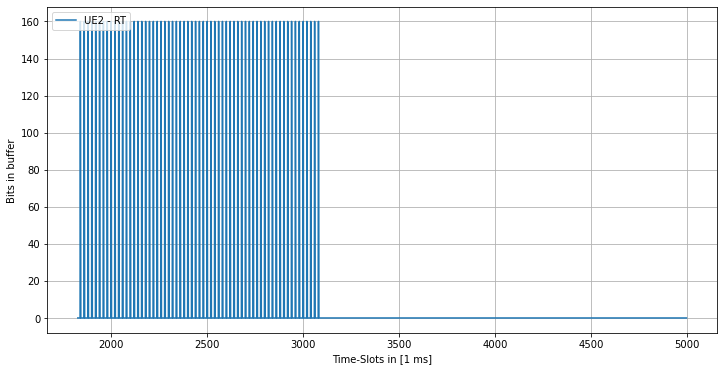

In [5]:
for i in np.arange(len(ue_comp)):
    if(ue_comp[i].qos==2):
        stream=i
    if(ue_comp[i].qos==1):    
        rt=i
    if(ue_comp[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
#plt.plot(list(ue_comp[stream].mon.keys())[1000:3000],list(ue_comp[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_comp[rt].mon.keys())[1000:3000],list(ue_comp[rt].mon.values())[1000:3000],label='UE2 - RT')
#plt.plot(list(ue_comp[nrt].mon.keys())[1000:3000],list(ue_comp[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

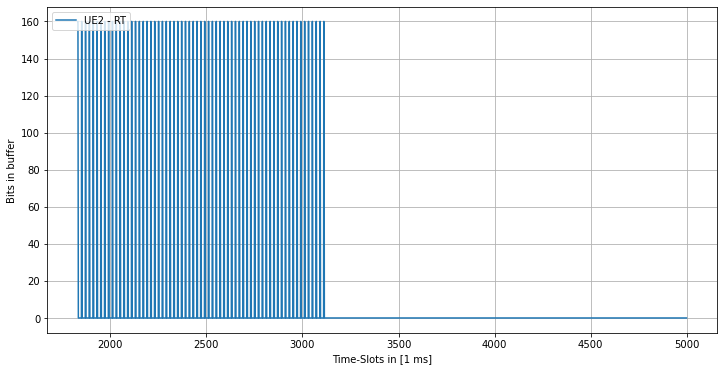

In [6]:
for i in np.arange(len(ue_list)):
    if(ue_list[i].qos==2):
        stream=i
    if(ue_list[i].qos==1):    
        rt=i
    if(ue_list[i].qos==0):
        nrt=i

plt.figure(figsize=(12,6))
#plt.plot(list(ue_list[stream].mon.keys())[1000:3000],list(ue_list[stream].mon.values())[1000:3000],label='UE1 - streamer')
plt.plot(list(ue_list[rt].mon.keys())[1000:3000],list(ue_list[rt].mon.values())[1000:3000],label='UE2 - RT')
#plt.plot(list(ue_list[nrt].mon.keys())[1000:3000],list(ue_list[nrt].mon.values())[1000:3000],label='UE3 - NRT')
#plt.plot(list(ue_list[120].mon.keys())[1000:3000],list(ue_list[120].mon.values())[1000:3000],label='UE4')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

In [7]:
ue_list=ue_dict[19]
for i in ue_list:
    print('User')
    print(i.bits)
    print(i.mR)
    print(i.bits2)
    print(i.mR2)
    print(i.comp)

User
55877.5
26.516474484472948
200000.0
40.24877489969217
0
User
69905.0
26.651160636738975
196000.0
39.226360719679754
0
User
44394.0
16.81919102010471
165144.0
33.05723414638281
0
User
33514.0
12.67762049124022
123864.0
24.78500392867763
0
User
90930.0
34.72855197655243
194000.0
38.809602503567355
0
User
49700.0
18.945715457916705
186050.0
37.24163452013369
0
User
62407.5
23.825089440348282
196000.0
39.228712831400436
0
User
70370.0
26.631219005098647
204000.0
40.832834530614214
0
User
75703.75
29.104564054482665
200000.0
39.99342352813618
0
User
83300.0
31.954236979376642
200000.0
40.020562406720316
0
User
69207.5
26.51826879354094
194000.0
38.820867609901846
0
User
75703.75
29.244221843489075
194000.0
38.802630259315585
0
User
68897.5
26.580819025934492
192000.0
38.43852546924062
0
User
68277.5
26.535018854811785
196000.0
39.23837545194409
0
User
42756.0
16.684284227224087
164204.0
32.8956281726425
0
User
65177.5
26.572645507689945
200000.0
40.06296418084372
0
User
28242.0
10.8529

In [8]:
C=0
nC=0
for i in ue_all:
    print('C:', i.mR)
    print('nC:',i.mR2)
    print('C-queue:', i.queue.level)
    print('nC-queue:',i.queue2.level)
    print('nC-queue:',i.qos)
    nC=nC+i.mR2
    C=C+i.mR

C: 26.516474484472948
nC: 40.24877489969217
C-queue: 144122.5
nC-queue: 0.0
nC-queue: 0.0
C: 666.7666666666667
nC: 25.912552488809613
C-queue: 194000
nC-queue: 0.0
nC-queue: 0.0
C: 26.651160636738975
nC: 39.226360719679754
C-queue: 126095.0
nC-queue: 0.0
nC-queue: 0.0
C: 0.1
nC: 24.825059648393797
C-queue: 194000
nC-queue: 10596.0
nC-queue: 0.0
C: 16.81919102010471
nC: 33.05723414638281
C-queue: 151606.0
nC-queue: 30856.0
nC-queue: 0.0
C: 0.1
nC: 25.017458800498147
C-queue: 202000
nC-queue: 17946.0
nC-queue: 0.0
C: 12.67762049124022
nC: 24.78500392867763
C-queue: 166486.0
nC-queue: 76136.0
nC-queue: 0.0
C: 34.72855197655243
nC: 38.809602503567355
C-queue: 103070.0
nC-queue: 0.0
nC-queue: 0.0
C: 18.945715457916705
nC: 37.24163452013369
C-queue: 146300.0
nC-queue: 9950.0
nC-queue: 0.0
C: 23.825089440348282
nC: 39.228712831400436
C-queue: 133592.5
nC-queue: 0.0
nC-queue: 0.0
C: 0.1
nC: 21.322263570581757
C-queue: 200000
nC-queue: 42752.0
nC-queue: 0.0
C: 2000.1
nC: 18.09357981216871
C-que

In [9]:
mean_tbs=0
for i in ue_all:
    mean_tbs+=i.tbs
    
mean_tbs=mean_tbs/len(ue_all)

mean_tbs2=0
ue_list=ue_dict[19]
for i in ue_list:
    mean_tbs2+=i.tbs
ue_list=ue_dict[20]
for i in ue_list:
    mean_tbs2+=i.tbs
    
mean_tbs2=mean_tbs2/(len(ue_dict[19])+len(ue_dict[20]))

In [10]:
print('all:',mean_tbs)
print('no comp:',mean_tbs2)

all: 53.003571428571426
no comp: 62.85539215686274


In [11]:
ue_all_19=ue_all[0:69]
av=0
for i in ue_all_19:
    av+=i.mR2/i.mR
    print(i.mR2)
    print(i.mR)
av=av/70

40.24877489969217
26.516474484472948
25.912552488809613
666.7666666666667
39.226360719679754
26.651160636738975
24.825059648393797
0.1
33.05723414638281
16.81919102010471
25.017458800498147
0.1
24.78500392867763
12.67762049124022
38.809602503567355
34.72855197655243
37.24163452013369
18.945715457916705
39.228712831400436
23.825089440348282
21.322263570581757
0.1
18.09357981216871
2000.1
25.28356410409135
2000.1
24.78782492998341
0.1
40.832834530614214
26.631219005098647
39.99342352813618
29.104564054482665
40.020562406720316
31.954236979376642
38.820867609901846
26.51826879354094
38.802630259315585
29.244221843489075
18.11362842480055
0.1
38.43852546924062
26.580819025934492
39.23837545194409
26.535018854811785
24.85161904297747
0.1
32.8956281726425
16.684284227224087
40.06296418084372
26.572645507689945
21.362820472631995
10.85296705339282
39.17206667580172
34.78183517077012
39.93249859804281
23.97925837512228
26.206417254180714
0.1
24.8369621576266
0.1
28.72940924484119
14.6420356089

In [12]:
av

45.709710774554004

In [13]:
print('comp prb perc',prb_number_comp/(prb_number_normal+prb_number_comp))
print('comp user perc',len(ue_comp)/len(ue_all))

comp prb perc 0.64
comp user perc 0.2714285714285714
